---
# Predictive Modeling 
# Author: Adefemi Abimbola
---


In [47]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from tqdm import tqdm
import matplotlib.dates as mdates
import ast
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#path to each cleaned data set unique to your system
review_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/reviews.csv'
business_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/business.csv'
user_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/user.csv'
checkin_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/checkin.csv'
tip_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/tip.csv'

In [4]:
# read the data
review = pd.read_csv(review_path)
business = pd.read_csv(business_path)
user = pd.read_csv(user_path)
checkin = pd.read_csv(checkin_path)
tip = pd.read_csv(tip_path)

In [5]:
# Aggregating the dataset into a master dataset
business.rename(columns={'name': 'business_name',
                         'address': 'business_address',
                         'city': 'business_city',
                         'stars': 'business_stars',
                         'review_count':'business_review_count',
                         'attributes':'business_attributes',
                         'categories':'business_categories',
                         'hours':'business_hours'}, inplace=True)
business.drop(columns=['is_open'], inplace=True)
review.rename(columns={'stars': 'review_stars',
                       'date': 'review_date',
                       'text': 'review'}, inplace=True)
review.drop(columns=['useful', 'funny','cool'], inplace=True)
user.rename(columns={'name': 'user_name',
                     'review_count': 'user_review_count',
                     'average_stars': 'user_average_stars',
                     'compliments_total': 'User_compliments_total'}, inplace=True)
user.drop(columns=['elite', 'fans'], inplace=True)
checkin.rename(columns={'date': 'checkin_dates'}, inplace=True)
master = review.merge(business, on='business_id', how='left')
master = master.merge(user, on='user_id', how='left')
master = master.merge(checkin, on='business_id', how='left')
master.dropna(inplace=True)

# master dataset created each row represents one review

In [ ]:
master.columns

In [ ]:
master.head()

---
- Predicting business star rating using simple features
    - Baseline Model - Linear regression
    - Final Model - Gradient Boosting
-  Built models to predict business star ratings using simple features; used Linear Regression as a baseline and Gradient Boosting as the primary model.
---

In [6]:
def extract_attribute(attr_str, key):
    try:
        attr_dict = ast.literal_eval(attr_str)
        return attr_dict.get(key, None)
    except:
        return None


In [7]:
def extract_parking_type(attr_str, parking_type):
    try:
        attr_dict = ast.literal_eval(attr_str)
        parking_str = attr_dict.get('BusinessParking')
        parking_dict = ast.literal_eval(parking_str) if parking_str else {}
        return parking_dict.get(parking_type, None)
    except:
        return None

In [8]:
def simplify_category(cat_string):
    if not isinstance(cat_string, str):
        return 'Other'
    
    cat_string = cat_string.lower()

    if 'restaurant' in cat_string or 'food' in cat_string:
        return 'Restaurant'
    elif 'shopping' in cat_string or 'store' in cat_string:
        return 'Retail'
    elif 'health' in cat_string or 'medical' in cat_string or 'nutritionist' in cat_string:
        return 'Health'
    elif 'beauty' in cat_string or 'spa' in cat_string or 'salon' in cat_string:
        return 'Beauty'
    elif 'bar' in cat_string or 'nightlife' in cat_string or 'club' in cat_string:
        return 'Nightlife'
    elif 'education' in cat_string or 'school' in cat_string:
        return 'Education'
    elif 'service' in cat_string or 'notary' in cat_string:
        return 'Professional Services'
    elif 'public service' in cat_string or 'government' in cat_string:
        return 'Government'
    elif 'automotive' in cat_string or 'car' in cat_string or 'mechanic' in cat_string or 'tire' in cat_string:
        return 'Automotive'
    elif 'gym' in cat_string or 'fitness' in cat_string or 'yoga' in cat_string or 'active life' in cat_string:
        return 'Fitness'
    elif 'pets' in cat_string or 'animal' in cat_string or 'veterinary' in cat_string:
        return 'Veterinary'
    elif 'hotel' in cat_string or 'lodging' in cat_string or 'travel' in cat_string:
        return 'Travel'
    elif 'church' in cat_string or 'temple' in cat_string or 'synagogue' in cat_string or 'place of worship' in cat_string:
        return 'Religious'
    elif 'movie' in cat_string or 'cinema' in cat_string or 'theater' in cat_string or 'art' in cat_string or 'museum' in cat_string or 'entertainment' in cat_string:
        return 'Entertainment'
    elif 'media' in cat_string or 'news' in cat_string or 'radio' in cat_string or 'television' in cat_string:
        return 'Media/Station'
    else:
        return 'Other'


In [9]:
# Preparing Data for Modeling 
master['review_length'] = master['review'].apply(lambda x: len(str(x).split()))

master['Wifi'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'WiFi'))
master['credit_cards'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'BusinessAcceptsCreditCards'))
master['bike_parking'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'BikeParking'))
master['parking_garage'] = master['business_attributes'].apply(lambda x: extract_parking_type(x, 'garage'))
master['parking_lot'] = master['business_attributes'].apply(lambda x: extract_parking_type(x, 'lot'))
master['parking_street'] = master['business_attributes'].apply(lambda x: extract_parking_type(x, 'street'))

# Encode WiFi
master['Wifi'].replace({"'free'": 2, "None": 1, "u'no'": 0, "u'free'": 2, "'no'": 0, "u'paid'": 1, "'paid'": 1,"'None'": 0}, inplace=True)
master['Wifi'] = master['Wifi'].fillna(0)

# simplifying the business categories
master['category_simple'] = master['business_categories'].apply(simplify_category)

/var/folders/t5/97cjl4mx5td1_8pcvlh1hxn80000gp/T/ipykernel_53430/3947988532.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master['Wifi'].replace({"'free'": 2, "None": 1, "u'no'": 0, "u'free'": 2, "'no'": 0, "u'paid'": 1, "'paid'": 1,"'None'": 0}, inplace=True)
/var/folders/t5/97cjl4mx5td1_8pcvlh1hxn80000gp/T/ipykernel_53430/3947988532.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)

In [ ]:
# Dropping unnecessary columns and creating a seperate dataframe
business_df = master.groupby('business_id').agg({
    'review_stars': 'mean',  # Avg rating from users
    'user_review_count': 'mean',
    'user_average_stars': 'mean',
    'User_compliments_total': 'mean',
    'review_length': 'mean',
    'checkin_dates': lambda x: len(x.dropna()),  # num check-ins
    'Wifi': 'first',  # drop one later if duplicate
    'credit_cards': 'first',
    'bike_parking': 'first',
    'parking_garage': 'first',
    'parking_lot': 'first',
    'parking_street': 'first',
    'category_simple': 'first',
    'business_review_count': 'first',
    'business_stars': 'first',  # TARGET
})

business_df = business_df.reset_index()

# Converting categorical features to integers or binary columns
categorical_features = ['category_simple']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(business_df[categorical_features])

# Convert encoded to a DataFrame and concat with original
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))
business_df = pd.concat([business_df.reset_index(drop=True), encoded_df], axis=1)

# Drop original categorical column
business_df.drop(columns=categorical_features, inplace=True)



- Baseline Model - Linear Regression
___

In [ ]:
# Drop column business start review that is what we are predictiing 
drop_col = ['business_stars','business_id']

#Define X and y 
X = business_df.drop(columns=drop_col)
y = business_df['business_stars']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Convert categorical features to int
for col in categorical_features:
    business_df[col] = business_df[col].map({'True': 1, 'False': 0, None: 0, 'None': 0}).fillna(0)
    

In [ ]:
# tarin the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict the test set
y_pred = lr.predict(X_test)

# Evaluate the model
lr_mae = mean_absolute_error(y_test, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lr_r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Baseline:")
print(f"Mean Absolute Error : {lr_mae:.4f}")
print(f"Root Mean-Square Error: {lr_rmse:.4f}")
print(f"R² Score: {lr_r2:.4f}")

# Cross-Validation (5-Fold)
lr_cv_mae = -cross_val_score(lr, X, y, cv=5, scoring='neg_mean_absolute_error')
lr_cv_r2 = cross_val_score(lr, X, y, cv=5, scoring='r2')
lr_y_pred_cv = cross_val_predict(lr, X, y, cv=5)
lr_cv_rmse = np.sqrt(mean_squared_error(y, lr_y_pred_cv))

print("\n📊 5-Fold Cross-Validation:")
print(f"Average MAE:  {lr_cv_mae.mean():.4f} (std: {lr_cv_mae.std():.4f})")
print(f"Average RMSE: {lr_cv_rmse:.4f}")
print(f"Average R²:   {lr_cv_r2.mean():.4f} (std: {lr_cv_r2.std():.4f})")



In [ ]:
# plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
#plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Baseline Model - Linear Regression: Actual vs Predicted Ratings')

- Final Model - Gradient Boosting
---

In [ ]:
# x-train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

# Predictions on test set
y_pred = gbr.predict(X_test)

# Evaluate on test set
mae_gbr = mean_absolute_error(y_test, y_pred)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_gbr = r2_score(y_test, y_pred)

print("🔍 Gradient Boosting on Test Set:")
print(f"Mean Absolute Error:  {mae_gbr:.4f}")
print(f"Root Mean-Square Error: {rmse_gbr:.4f}")
print(f"R²:   {r2_gbr:.4f}")

# Cross-Validation (5-Fold)
cv_mae_gbr = -cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_r2_gbr = cross_val_score(gbr, X, y, cv=5, scoring='r2')
y_pred_cv_gbr = cross_val_predict(gbr, X, y, cv=5)
cv_rmse_gbr = np.sqrt(mean_squared_error(y, y_pred_cv))

print("\n📊 5-Fold Cross-Validation:")
print(f"Average MAE:  {cv_mae_gbr.mean():.4f} (std: {cv_mae_gbr.std():.4f})")
print(f"Average RMSE: {cv_rmse_gbr:.4f}")
print(f"Average R²:   {cv_r2_gbr.mean():.4f} (std: {cv_r2_gbr.std():.4f})")


In [ ]:
# plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Gradient Boosting: Actual vs Predicted Ratings')
plt.show()


In [ ]:
# comparing the baseline model to the final model

print("\n🔍 Test Set Evaluation:")
print(f"{'Metric':<8} {'Linear Reg':>12} {'Gradient Boost':>18}")
print(f"{'MAE':<10} {lr_mae:.4f} {mae_gbr:>18.4f}")
print(f"{'RMSE':<10} {lr_rmse:.4f} {rmse_gbr:>18.4f}")
print(f"{'R²':<10} {lr_r2:.4f} {r2_gbr:>18.4f}")

print("\n📊 5-Fold Cross-Validation:")
print(f"{'Metric':<8} {'Linear Reg':>12} {'Gradient Boost':>18}")
print(f"{'MAE':<10} {lr_cv_mae.mean():.4f} {cv_mae_gbr.mean():>18.4f}")
print(f"{'RMSE':<10} {lr_cv_rmse:.4f} {cv_rmse_gbr:>18.4f}")
print(f"{'R²':<10} {lr_cv_r2.mean():.4f} {cv_r2_gbr.mean():>18.4f}")


---
- Classifying business success level (Struggling, Stable, Successful) based on operational and user-related features
    - Baseline Model – Most Frequent Class
    - Final Model – Gradient Boosting Classifier
- Built models to classify business success levels (Struggling, Stable, Successful) based on operational and user-related features; used Most Frequent Class as a baseline and Gradient Boosting Classifier as the primary model.
---

In [ ]:
business_df

In [ ]:
business_df.columns

In [ ]:
def classify_business(stars):
    if stars < 3.0:
        return 'Struggling'
    elif stars < 4.0:
        return 'Stable'
    else:
        return 'Successful'

business_df['business_status'] = business_df['business_stars'].apply(classify_business)

business_df['business_status'].value_counts()


In [ ]:
X_class = business_df.drop(columns=['business_stars', 'business_status','business_id'])  # drop target + optional
y_class = business_df['business_status']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)


- Baseline Model – Most Frequent Class
---

In [ ]:
# Create and train the baseline model
baseline_clf = DummyClassifier(strategy='most_frequent')
baseline_clf.fit(X_train_clf, y_train_clf)

# Predict and evaluate
y_pred_baseline = baseline_clf.predict(X_test_clf)

cv_scores_baseline = cross_val_score(baseline_clf, X_class, y_class,cv=5, scoring='f1_weighted')

print("📉 Baseline Model (Most Frequent Class):\n")
print(classification_report(y_test_clf, y_pred_baseline))
print("Confusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_baseline))

print("📉 Baseline Model - 5-Fold CV F1 (weighted):")
print("Scores:", cv_scores_baseline)
print("Average F1:", np.mean(cv_scores_baseline))

- Final Model – Gradient Boosting Classifier
---

In [ ]:
# train the model
gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42)
gbc.fit(X_train_clf, y_train_clf)

y_pred_gbc = gbc.predict(X_test_clf)

print("🌟 Gradient Boosting Classifier:\n")
print(classification_report(y_test_clf, y_pred_gbc))
print("Confusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_gbc))

cv_scores_gbc = cross_val_score(gbc, X_class, y_class,cv=5, scoring='f1_weighted')

print("\n🌟 Gradient Boosting Classifier - 5-Fold CV F1 (weighted):")
print("Scores:", cv_scores_gbc)
print("Average F1:", np.mean(cv_scores_gbc))

In [ ]:
print("\n📊 5-Fold Cross-Validation Comparison (F1-weighted):")
print(f"{'Model':<25} {'F1 Scores':<40} {'Average F1':>12}")
print("-" * 80)
print(f"{'Baseline (Most Frequent)':<25} {str(cv_scores_baseline.tolist()):<40} {np.mean(cv_scores_baseline):>12.4f}")
print(f"{'Gradient Boosting':<25} {str(cv_scores_gbc.tolist()):<40} {np.mean(cv_scores_gbc):>12.4f}")


---
- Forecasting business activity over time (reviews and check-ins) using historical patterns
    - Baseline Model – Naive Forecast
    - Final Model – Time Series Regression (e.g., Gradient Boosting or ARIMA)
- Built models to forecast review volume and check-in frequency for businesses over a 6-month horizon using historical activity data; implemented a Naive Forecast as a baseline and used Gradient Boosting Regressor for advanced time series predictions.
---

In [11]:
## Prep the data for time series analysis

master['review_date'] = pd.to_datetime(master['review_date'], errors='coerce')
master['year_month'] = master['review_date'].dt.to_period('M').astype(str)
reviews_monthly = (master.groupby(['business_id', 'year_month']).size().reset_index(name='review_count'))

checkin_expanded = master[['business_id', 'checkin_dates']].dropna().copy()
checkin_expanded = checkin_expanded.drop_duplicates(subset=['business_id'])

checkin_expanded['checkin_dates'] = checkin_expanded['checkin_dates'].str.split(', ')
checkin_expanded = checkin_expanded.explode('checkin_dates')
checkin_expanded['checkin_datetime'] = pd.to_datetime(checkin_expanded['checkin_dates'], errors='coerce')
checkin_expanded = checkin_expanded.dropna(subset=['checkin_datetime'])
checkin_expanded['year_month'] = checkin_expanded['checkin_datetime'].dt.to_period('M').astype(str)

checkins_monthly = (checkin_expanded.groupby(['business_id', 'year_month']).size().reset_index(name='checkin_count'))

time_series_df = pd.merge(reviews_monthly, checkins_monthly, on=['business_id', 'year_month'], how='outer').fillna(0)

time_series_df['year_month'] = pd.to_datetime(time_series_df['year_month'])
time_series_df = time_series_df.sort_values(['business_id', 'year_month']).reset_index(drop=True)

- Baseline Model – Naive Forecast
---

In [24]:
# Get business with the most monthly data
top_business = time_series_df['business_id'].value_counts().idxmax()

In [25]:
# Filter time series for that business
biz_ts = time_series_df[time_series_df['business_id'] == top_business].copy()
biz_ts = biz_ts.sort_values('year_month')

In [40]:
# Get the last known month and values
biz_ts['year_month'] = pd.to_datetime(biz_ts['year_month'])
last_month = biz_ts['year_month'].max()
last_reviews = biz_ts.loc[biz_ts['year_month'] == last_month, 'review_count'].values[0]
last_checkins = biz_ts.loc[biz_ts['year_month'] == last_month, 'checkin_count'].values[0]

# Create forecast dates
future_months = pd.date_range(start=last_month + pd.offsets.MonthBegin(1), periods=6, freq='MS')

# Build the forecast DataFrame
naive_forecast = pd.DataFrame({
    'business_id': top_business,
    'year_month': future_months,
    'review_count_naive': last_reviews,
    'checkin_count_naive': last_checkins
})


In [41]:
print("📊 Naive Forecast for Business:")
print(naive_forecast)


📊 Naive Forecast for Business:
              business_id year_month  review_count_naive  checkin_count_naive
0  6RBZfirnzE4NahJTn1UPNA 2022-02-01                 6.0                  4.0
1  6RBZfirnzE4NahJTn1UPNA 2022-03-01                 6.0                  4.0
2  6RBZfirnzE4NahJTn1UPNA 2022-04-01                 6.0                  4.0
3  6RBZfirnzE4NahJTn1UPNA 2022-05-01                 6.0                  4.0
4  6RBZfirnzE4NahJTn1UPNA 2022-06-01                 6.0                  4.0
5  6RBZfirnzE4NahJTn1UPNA 2022-07-01                 6.0                  4.0


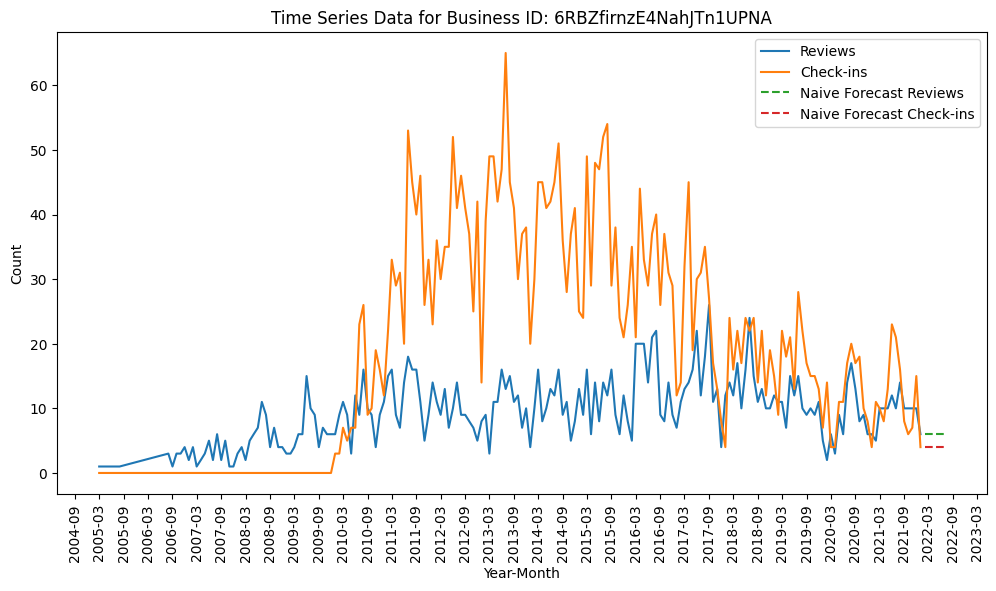

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(biz_ts['year_month'], biz_ts['review_count'], label='Reviews')
ax.plot(biz_ts['year_month'], biz_ts['checkin_count'], label='Check-ins')
ax.plot(naive_forecast['year_month'], naive_forecast['review_count_naive'], label='Naive Forecast Reviews', linestyle='--')
ax.plot(naive_forecast['year_month'], naive_forecast['checkin_count_naive'], label='Naive Forecast Check-ins', linestyle='--')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Count')
ax.set_title(f'Time Series Data for Business ID: {top_business}')
ax.legend()
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # show every 3 months

plt.show()